In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("/content/cleaned_ghc_train.csv")


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

df['text'] = df['text'].fillna('')

In [3]:
y = df['label']
X=df['text']

# **Bidirectional LSTM**

A Bidirectional Long Short-Term Memory (BiLSTM) is a type of recurrent neural network (RNN) architecture that improves upon the standard LSTM by processing the input data in both forward and backward directions. This allows the model to capture information from both past and future states, which can be particularly useful for sequence data where context from both directions can enhance understanding and prediction.

A BiLSTM consists of two LSTM layers: one processes the sequence forward (from the start to the end), and the other processes it backward (from the end to the start).
At each time step, the outputs of both LSTM layers are concatenated or combined to form the final output. This combination captures context from both directions, making the model more effective in understanding the entire sequence.

Epoch 1/5
273/273 [==============================] - 39s 116ms/step - loss: 0.6074 - accuracy: 0.7025 - val_loss: 0.5398 - val_accuracy: 0.7805
Epoch 2/5
273/273 [==============================] - 15s 53ms/step - loss: 0.3986 - accuracy: 0.8478 - val_loss: 0.5186 - val_accuracy: 0.7975
Epoch 3/5
273/273 [==============================] - 12s 45ms/step - loss: 0.2780 - accuracy: 0.8846 - val_loss: 0.4982 - val_accuracy: 0.7695
Epoch 4/5
273/273 [==============================] - 12s 45ms/step - loss: 0.1781 - accuracy: 0.9261 - val_loss: 0.4599 - val_accuracy: 0.8345
Epoch 5/5
273/273 [==============================] - 12s 43ms/step - loss: 0.1331 - accuracy: 0.9473 - val_loss: 0.6558 - val_accuracy: 0.7725
137/137 - 1s - loss: 0.6558 - accuracy: 0.7725 - 1s/epoch - 11ms/step

Test accuracy: 0.7724977135658264
137/137 [==============================] - 3s 12ms/step


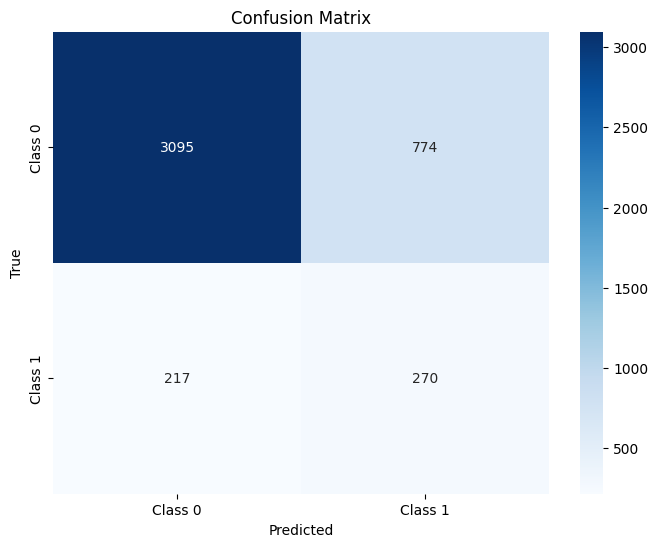

              precision    recall  f1-score   support

     Class 0       0.93      0.80      0.86      3869
     Class 1       0.26      0.55      0.35       487

    accuracy                           0.77      4356
   macro avg       0.60      0.68      0.61      4356
weighted avg       0.86      0.77      0.81      4356



In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your dataset features and labels
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
top_words = 10000
max_review_length = 200

# Tokenization
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_review_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_review_length)

# Compute class weights:The provided code snippet uses the compute_class_weight function from the sklearn.utils.class_weight module to compute weights for classes in the training data. These weights help handle class imbalance by assigning more importance to underrepresented classes during model training.
#'balanced': This argument tells the function to automatically adjust weights inversely proportional to the class frequencies. It ensures that each class contributes equally to the loss function during model training.
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


# Define the model
embedding_vector_length = 100  #embedding dimension
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))  # Add Dropout for regularization
# Another LSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.4))  # Add Dropout for regularization
# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))  # Add Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
# Calculate and print additional metrics
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.7724977043158862
Recall: 0.5544147843942505
Precision: 0.25862068965517243
F1 Score: 0.3527106466361855
ROC AUC Score: 0.7445158509990696


# Decreasing dropouts layer value




Epoch 1/5
273/273 [==============================] - 36s 104ms/step - loss: 0.6148 - accuracy: 0.7148 - val_loss: 0.6296 - val_accuracy: 0.7071
Epoch 2/5
273/273 [==============================] - 14s 53ms/step - loss: 0.4195 - accuracy: 0.8282 - val_loss: 0.5343 - val_accuracy: 0.7360
Epoch 3/5
273/273 [==============================] - 14s 52ms/step - loss: 0.3037 - accuracy: 0.8755 - val_loss: 0.4165 - val_accuracy: 0.8499
Epoch 4/5
273/273 [==============================] - 13s 48ms/step - loss: 0.2059 - accuracy: 0.9147 - val_loss: 0.5444 - val_accuracy: 0.7899
Epoch 5/5
273/273 [==============================] - 12s 44ms/step - loss: 0.1352 - accuracy: 0.9428 - val_loss: 0.5876 - val_accuracy: 0.8166
137/137 - 2s - loss: 0.5876 - accuracy: 0.8166 - 2s/epoch - 11ms/step

Test accuracy: 0.8165748119354248
137/137 [==============================] - 3s 13ms/step


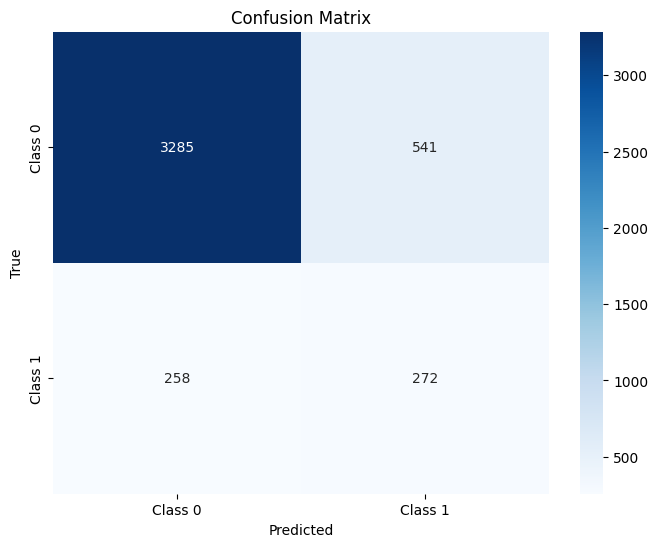

              precision    recall  f1-score   support

     Class 0       0.93      0.86      0.89      3826
     Class 1       0.33      0.51      0.41       530

    accuracy                           0.82      4356
   macro avg       0.63      0.69      0.65      4356
weighted avg       0.86      0.82      0.83      4356



In [8]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your dataset features and labels
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
top_words = 10000
max_review_length = 200

# Tokenization
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_review_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_review_length)

# Compute class weights:The provided code snippet uses the compute_class_weight function from the sklearn.utils.class_weight module to compute weights for classes in the training data. These weights help handle class imbalance by assigning more importance to underrepresented classes during model training.
#'balanced': This argument tells the function to automatically adjust weights inversely proportional to the class frequencies. It ensures that each class contributes equally to the loss function during model training.
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


# Define the model
embedding_vector_length = 100  #embedding dimension
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))  # Add Dropout for regularization
# Another LSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.3))  # Add Dropout for regularization
# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Add Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


Looking at the recall metrics it does not improve much

# Increasing embedding length to 200

Epoch 1/5
273/273 [==============================] - 45s 138ms/step - loss: 0.6061 - accuracy: 0.6902 - val_loss: 0.5236 - val_accuracy: 0.7544
Epoch 2/5
273/273 [==============================] - 18s 66ms/step - loss: 0.4134 - accuracy: 0.8403 - val_loss: 0.5051 - val_accuracy: 0.7874
Epoch 3/5
273/273 [==============================] - 15s 55ms/step - loss: 0.2711 - accuracy: 0.8868 - val_loss: 0.4981 - val_accuracy: 0.8012
Epoch 4/5
273/273 [==============================] - 13s 49ms/step - loss: 0.1642 - accuracy: 0.9313 - val_loss: 0.6201 - val_accuracy: 0.7707
Epoch 5/5
273/273 [==============================] - 14s 51ms/step - loss: 0.1138 - accuracy: 0.9511 - val_loss: 0.7710 - val_accuracy: 0.7677
137/137 - 2s - loss: 0.7710 - accuracy: 0.7677 - 2s/epoch - 15ms/step

Test accuracy: 0.7676767706871033
137/137 [==============================] - 3s 11ms/step


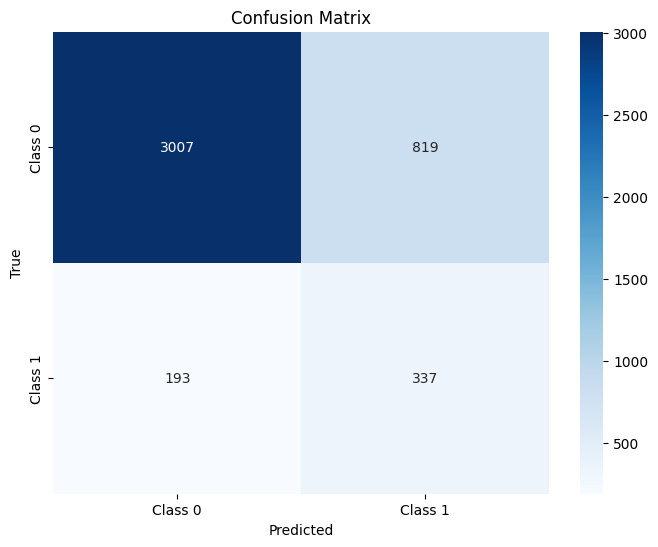

              precision    recall  f1-score   support

     Class 0       0.94      0.79      0.86      3826
     Class 1       0.29      0.64      0.40       530

    accuracy                           0.77      4356
   macro avg       0.62      0.71      0.63      4356
weighted avg       0.86      0.77      0.80      4356



In [11]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your dataset features and labels
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
top_words = 10000
max_review_length = 200

# Tokenization
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_review_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_review_length)

# Compute class weights:The provided code snippet uses the compute_class_weight function from the sklearn.utils.class_weight module to compute weights for classes in the training data. These weights help handle class imbalance by assigning more importance to underrepresented classes during model training.
#'balanced': This argument tells the function to automatically adjust weights inversely proportional to the class frequencies. It ensures that each class contributes equally to the loss function during model training.
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


# Define the model
embedding_vector_length = 200  #embedding dimension
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))  # Add Dropout for regularization
# Another LSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.3))  # Add Dropout for regularization
# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Add Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
# Calculate and print additional metrics
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.7676767676767676
Recall: 0.6358490566037736
Precision: 0.291522491349481
F1 Score: 0.3997627520759194
ROC AUC Score: 0.7665084476619751


The model has improved by watching the recall i.e 63%

# Increasing embedding layer to 220

Epoch 1/5
273/273 [==============================] - 46s 140ms/step - loss: 0.6124 - accuracy: 0.6927 - val_loss: 0.5518 - val_accuracy: 0.7975
Epoch 2/5
273/273 [==============================] - 18s 64ms/step - loss: 0.4175 - accuracy: 0.8344 - val_loss: 0.3578 - val_accuracy: 0.8526
Epoch 3/5
273/273 [==============================] - 16s 58ms/step - loss: 0.2859 - accuracy: 0.8816 - val_loss: 0.4582 - val_accuracy: 0.8106
Epoch 4/5
273/273 [==============================] - 15s 53ms/step - loss: 0.1853 - accuracy: 0.9177 - val_loss: 0.5563 - val_accuracy: 0.7782
Epoch 5/5
273/273 [==============================] - 14s 51ms/step - loss: 0.1235 - accuracy: 0.9431 - val_loss: 0.6424 - val_accuracy: 0.7904
137/137 - 2s - loss: 0.6424 - accuracy: 0.7904 - 2s/epoch - 13ms/step

Test accuracy: 0.7904040217399597
137/137 [==============================] - 3s 12ms/step


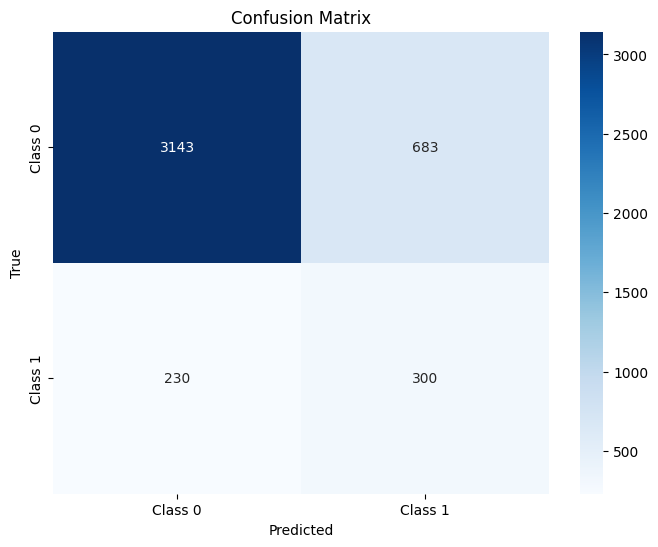

              precision    recall  f1-score   support

     Class 0       0.93      0.82      0.87      3826
     Class 1       0.31      0.57      0.40       530

    accuracy                           0.79      4356
   macro avg       0.62      0.69      0.63      4356
weighted avg       0.86      0.79      0.82      4356



In [13]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your dataset features and labels
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
top_words = 10000
max_review_length = 200

# Tokenization
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_review_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_review_length)

# Compute class weights:The provided code snippet uses the compute_class_weight function from the sklearn.utils.class_weight module to compute weights for classes in the training data. These weights help handle class imbalance by assigning more importance to underrepresented classes during model training.
#'balanced': This argument tells the function to automatically adjust weights inversely proportional to the class frequencies. It ensures that each class contributes equally to the loss function during model training.
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


# Define the model
embedding_vector_length = 220  #embedding dimension
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))  # Add Dropout for regularization
# Another LSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.3))  # Add Dropout for regularization
# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Add Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


The recall is again decreased , so the model is not performing well compare to embedding layer of 200

# **CNN with BLSTM**

Epoch 1/5
273/273 [==============================] - 38s 115ms/step - loss: 0.5907 - accuracy: 0.7258 - val_loss: 0.4670 - val_accuracy: 0.7938
Epoch 2/5
273/273 [==============================] - 18s 67ms/step - loss: 0.4199 - accuracy: 0.8368 - val_loss: 0.6086 - val_accuracy: 0.7371
Epoch 3/5
273/273 [==============================] - 16s 59ms/step - loss: 0.2854 - accuracy: 0.8781 - val_loss: 0.4149 - val_accuracy: 0.8228
Epoch 4/5
273/273 [==============================] - 15s 56ms/step - loss: 0.1885 - accuracy: 0.9276 - val_loss: 0.6548 - val_accuracy: 0.7888
Epoch 5/5
273/273 [==============================] - 15s 55ms/step - loss: 0.1164 - accuracy: 0.9579 - val_loss: 0.5968 - val_accuracy: 0.8191
137/137 - 2s - loss: 0.5968 - accuracy: 0.8191 - 2s/epoch - 12ms/step

Test accuracy: 0.8191000819206238
137/137 [==============================] - 3s 11ms/step


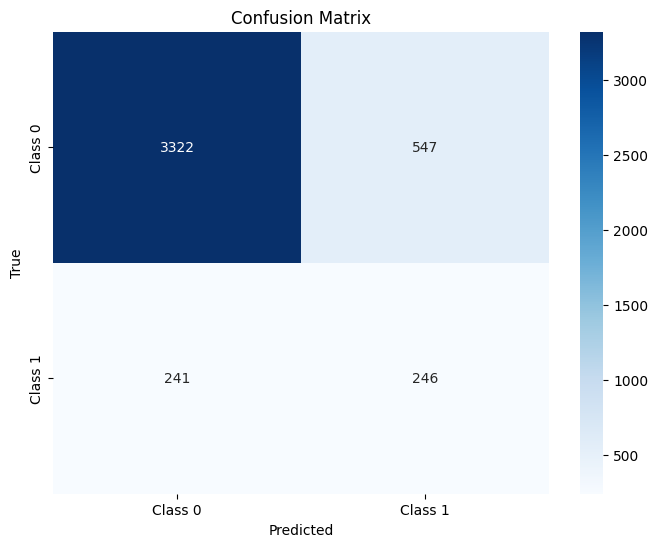

              precision    recall  f1-score   support

     Class 0       0.93      0.86      0.89      3869
     Class 1       0.31      0.51      0.38       487

    accuracy                           0.82      4356
   macro avg       0.62      0.68      0.64      4356
weighted avg       0.86      0.82      0.84      4356



In [15]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your dataset features and labels
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
top_words = 10000
max_review_length = 200

# Tokenization
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_review_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_review_length)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define the model
embedding_vector_length = 100  # Increase embedding dimension
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))

# CNN layer
model.add(Conv1D(filters=512, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Add Dropout for regularization

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Another LSTM layer
model.add(Bidirectional(LSTM(units=128)))

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Add Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
# Calculate and print additional metrics
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.8000459136822773
Recall: 0.5708418891170431
Precision: 0.2957446808510638
F1 Score: 0.38962859145059564
ROC AUC Score: 0.7664349329663523


I tried changing the embedding layer and dropouts value but it is not increasing the recall much

Epoch 1/5
273/273 [==============================] - 46s 141ms/step - loss: 0.6040 - accuracy: 0.7052 - val_loss: 0.6978 - val_accuracy: 0.7523
Epoch 2/5
273/273 [==============================] - 23s 84ms/step - loss: 0.4542 - accuracy: 0.8258 - val_loss: 0.6781 - val_accuracy: 0.6834
Epoch 3/5
273/273 [==============================] - 19s 68ms/step - loss: 0.3134 - accuracy: 0.8851 - val_loss: 0.5110 - val_accuracy: 0.8014
Epoch 4/5
273/273 [==============================] - 18s 66ms/step - loss: 0.1932 - accuracy: 0.9234 - val_loss: 0.4722 - val_accuracy: 0.8315
Epoch 5/5
273/273 [==============================] - 17s 61ms/step - loss: 0.1309 - accuracy: 0.9447 - val_loss: 0.6571 - val_accuracy: 0.8287
137/137 - 2s - loss: 0.6571 - accuracy: 0.8287 - 2s/epoch - 13ms/step

Test accuracy: 0.8287419676780701
137/137 [==============================] - 5s 12ms/step


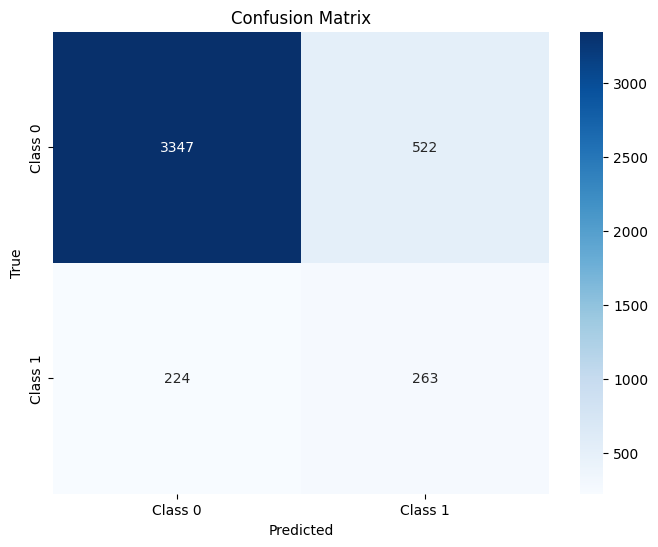

              precision    recall  f1-score   support

     Class 0       0.94      0.87      0.90      3869
     Class 1       0.34      0.54      0.41       487

    accuracy                           0.83      4356
   macro avg       0.64      0.70      0.66      4356
weighted avg       0.87      0.83      0.85      4356



In [21]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your dataset features and labels
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
top_words = 10000
max_review_length = 200

# Tokenization
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_review_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_review_length)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define the model
embedding_vector_length = 180  # Increase embedding dimension
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))

# CNN layer
model.add(Conv1D(filters=512, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Add Dropout for regularization

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model.add(Dropout(0.4))
# Another LSTM layer
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(0.3))
# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Add Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))
